In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import muon as mu
import logging
import scvi
import matplotlib.pyplot as plt
import os
import scipy
import seaborn as sns
from scipy import sparse

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
batches_to_keep = ["s1d1", "s1d2", "s1d3"]

## ATAC

In [3]:
atac = sc.read(
    "/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/neurips-multiome/atac_hvf.h5ad"
)
# atac = atac[atac.obs["batch"].isin(batches_to_keep)]
sc.pp.filter_genes(atac, min_cells=int(atac.shape[0] * 0.01))

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
atac.layers["X_counts"] = atac.layers["counts"].copy()
del atac.layers["counts"]

## RNA

In [10]:
rna = sc.read(
    "/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/neurips-multiome/rna_hvg.h5ad"
)
# rna = rna[rna.obs["batch"].isin(batches_to_keep)]
rna.X = rna.layers["counts"].copy()

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [11]:
rna.layers["X_counts"] = rna.layers["counts"].copy()
del rna.layers["counts"]

Plots

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

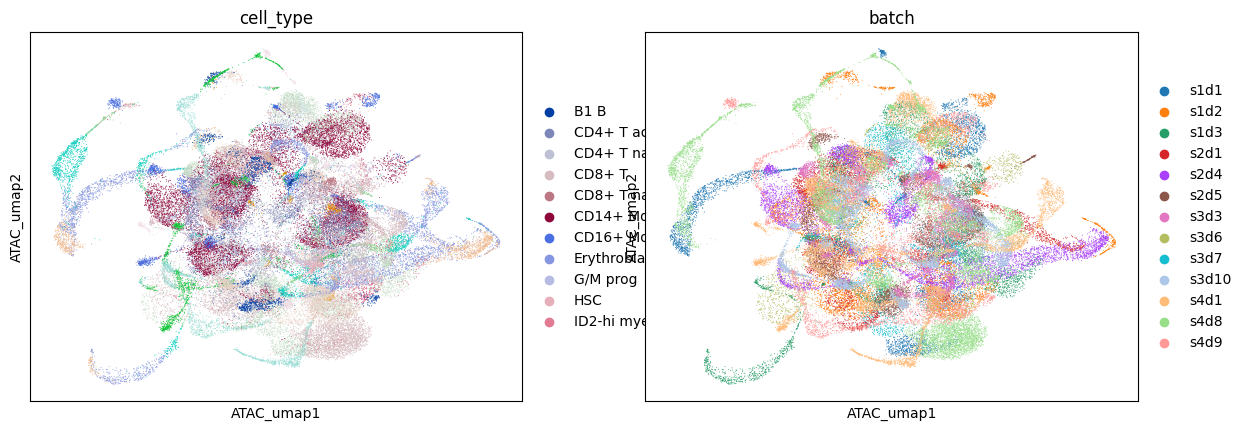

In [12]:
sc.pl.embedding(atac, basis="ATAC_umap", color=["cell_type", "batch"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

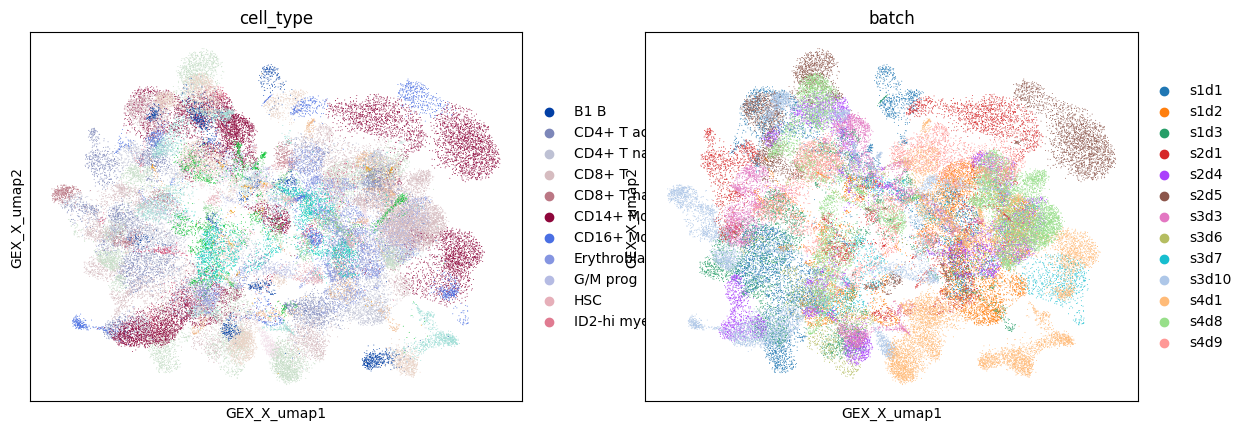

In [13]:
sc.pl.embedding(rna, basis="GEX_X_umap", color=["cell_type", "batch"])

## Check overdispersion

<Figure size 200x200 with 0 Axes>

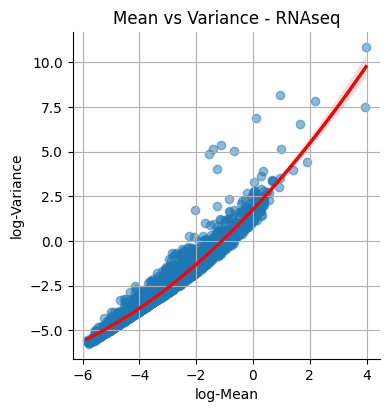

In [14]:
rna_mean_variance_df = pd.DataFrame({"Mean": np.log(rna.X.A.mean(0)), "Variance": np.log(rna.X.A.var(0))})

plt.figure(figsize=(2,2))
sns.lmplot(data=rna_mean_variance_df, x='Mean', y='Variance', order=2, ci=None, scatter_kws={'alpha':0.5}, height=4)
sns.regplot(data=rna_mean_variance_df, x='Mean', y='Variance', order=2, scatter=False, color='red')

plt.xlabel('log-Mean')
plt.ylabel('log-Variance')
plt.title('Mean vs Variance - RNAseq')
plt.grid(True)

plt.show()

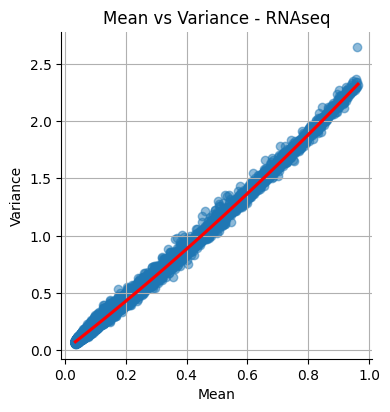

In [15]:
atac_mean_variance_df = pd.DataFrame({"Mean": atac.X.A.mean(0), "Variance": atac.X.A.var(0)})

sns.lmplot(data=atac_mean_variance_df, x='Mean', y='Variance', order=2, ci=None, scatter_kws={'alpha':0.5}, height=4)
sns.regplot(data=atac_mean_variance_df, x='Mean', y='Variance', order=2, scatter=False, color='red')

plt.xlabel('Mean')
plt.ylabel('Variance')
plt.title('Mean vs Variance - RNAseq')
plt.grid(True)
plt.show()

## collect under the same MuData object

In [16]:
mdata_multiome = mu.MuData({"rna": rna, "atac": atac})

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/mudata/_core/mudata.py:577: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_common = pd.concat(


In [17]:
mdata_multiome.var

,rna:highly_variable,rna:means,rna:dispersions,rna:dispersions_norm,atac:n_cells,atac:prop_shared_cells,atac:variability_score,feature_types,gene_id
C1orf159,True,0.189324,2.390527,0.602414,NaN,NaN,NaN,GEX,ENSG00000131591
SLC35E2B,True,0.243185,2.367481,0.468547,NaN,NaN,NaN,GEX,ENSG00000189339
SLC35E2A,True,0.201370,2.339411,0.305495,NaN,NaN,NaN,GEX,ENSG00000215790
TTC34,True,0.026749,2.329516,0.248018,NaN,NaN,NaN,GEX,ENSG00000215912
C1orf174,True,0.179411,2.396806,0.638885,NaN,NaN,NaN,GEX,ENSG00000198912
...,...,...,...,...,...,...,...,...,...
GL000195.1-32211-33062,NaN,NaN,NaN,NaN,3315.0,0.098557,0.598557,ATAC,NaN
GL000219.1-39933-40839,NaN,NaN,NaN,NaN,2484.0,0.074658,0.574658,ATAC,NaN
GL000219.1-42172-43054,NaN,NaN,NaN,NaN,4285.0,0.133273,0.633273,ATAC,NaN
GL000219.1-99257-100160,NaN,NaN,NaN,NaN,13328.0,0.442591,0.942591,ATAC,NaN


In [18]:
mdata_multiome.mod["rna"]

AnnData object with n_obs × n_vars = 69249 × 4000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ATAC_gene_activity_var_names', 'Site_colors', 'batch_colors', 'cell_type_colors', 'dataset_id', 'genome', 'hvg', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_umap'
    layers: 'X_counts'

In [19]:
mdata_multiome.mod["atac"]

AnnData object with n_obs × n_vars = 69249 × 40002
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay'
    var: 'feature_types', 'gene_id', 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism', 'cell_type_colors', 'batch_colors'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'binary', 'cpm', 'tf-idf', 'tf-idf-binary', 'tf-idf-counts', 'X_counts'

In [20]:
# Generate random indices for train and test sets
total_samples = mdata_multiome.n_obs
train_frac = 0.8
train_size = int(total_samples * train_frac)
train_indices = np.random.choice(total_samples, size=train_size, replace=False)
test_indices = np.setdiff1d(np.arange(total_samples), train_indices)

# Separate data into train and test sets by indexing the Anndata object
train_mdata_multiome = mdata_multiome[train_indices, :]
test_mdata_multiome = mdata_multiome[test_indices, :]

# Save results

In [33]:
mdata_multiome.write("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/atac/neurips/neurips_multiome.h5mu")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


In [34]:
train_mdata_multiome.write("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/atac/neurips/neurips_multiome_train.h5mu")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/mudata/_core/mudata.py:577: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_common = pd.concat(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/mudata/_core/mudata.py:760: ImplicitModificationWarning: Setting e

In [35]:
test_mdata_multiome.write("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/atac/neurips/neurips_multiome_test.h5mu")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/mudata/_core/mudata.py:577: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_common = pd.concat(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/mudata/_core/mudata.py:760: ImplicitModificationWarning: Setting e

## Add binarized version of neurips

In [2]:
mu_data = mu.read("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/atac/neurips/neurips_multiome.h5mu")
mu_data_train = mu.read("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/atac/neurips/neurips_multiome_train.h5mu")
mu_data_test = mu.read("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/atac/neurips/neurips_multiome_test.h5mu")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/mudata/_core/mudata.py:577: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_common = pd.concat(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype ar

In [3]:
mu_data["atac"].X = sparse.csr_matrix(np.where(mu_data["atac"].X.A>0., 1., 0.))
mu_data_train["atac"].X = sparse.csr_matrix(np.where(mu_data_train["atac"].X.A>0., 1., 0.))
mu_data_test["atac"].X = sparse.csr_matrix(np.where(mu_data_test["atac"].X.A>0., 1., 0.))

mu_data["atac"].layers["X_counts"] = mu_data["atac"].X.copy()
mu_data_train["atac"].layers["X_counts"] = mu_data_train["atac"].X.copy()
mu_data_test["atac"].layers["X_counts"] = mu_data_test["atac"].X.copy()

In [4]:
mu_data.write("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/atac/neurips_binary/neurips_multiome.h5mu")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


In [5]:
mu_data_train.write("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/atac/neurips_binary/neurips_multiome_train.h5mu")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


In [6]:
mu_data_test.write("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/atac/neurips_binary/neurips_multiome_test.h5mu")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c
